In [354]:
print('Last updated on', end=' ')
!date

Last updated on Wed Sep 18 15:20:42 PDT 2019


In [356]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()">
<input type="submit" value="Click here to toggle on/off the raw code.">
</form>''')

# Bayesian Neural Network with Tensorflow 2 and Tensorflow Probability

**Author: Arthur Lui**

This notebook provides an introduction to Tensorflow 2 and tensorflow probability.
The documentation and examples provide a lot of details. However, some of the inner-workings
were not immediately apparent to me. (Things like `DistributionLambda`, `Independent`, and the
`DenseVariational`.) So, I hope to provide more details here.

In [354]:
print('Last updated on', end=' ')
!date

Last updated on Wed Sep 18 15:20:42 PDT 2019


In [332]:
# Libraries for this notebook 
import sys

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tqdm import trange

In [151]:
# Set random seeds for reproducibility
np.random.seed(0)
tf.random.set_seed(0)

## Helper Functions

Here are a few helper functions for this tutorial. It may make more sense 
to skip these for now, and come back here when you see them being used later.

[1]: https://en.wikipedia.org/wiki/Rectifier_(neural_networks)#Softplus

In [246]:
def centered_softplus(x, c=np.log(np.expm1(1.)), eps=1e-5):
    """
    `softplus(x)` = $\log(1 + \exp(x))$ can be thought of as a smooth reLU.
    The centered softplus simply ensures that the returned values is always
    positive and is "centered" in the sense that `centered_softplus(0) = 1`.
    This function is useful in transforming a real parameter to a positive
    parameter. Exponentiating can be numerically unstable, making the 
    centered softplus a good alternative.
    """
    return tf.nn.softplus(c + x) + eps


# Define a generic negative loglikelihood function
# for computing a loss function
def neg_loglike(y, rv_y):
    """
    Compute negative log likelihood given a value (y)
    and the distribution (rv_y) of y.
    """
    # NOTE: I think these two are equivalent.
    #       All tutorials I've seen returns the commented version.
    #       But I think the uncommented version is more consistent
    #       with the convention that loss functions return scalars.
    
    # return -rv_y.log_prob(y)
    return -tf.reduce_mean(rv_y.log_prob(y))


def make_default_dense_prior(kernel_size, bias_size=0, dtype=None,
                             prior_mean=0, prior_sd=100):
    n = kernel_size + bias_size
    mu = [prior_mean] * n
    return tfp.layers.DistributionLambda(lambda _: tfd.Independent(
        tfd.Normal(loc=mu, scale=prior_sd),
        reinterpreted_batch_ndims=1))


def make_default_dense_guide(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        # Construct some trainable variational parameters
        # of the appropriate data type.
        # `VariableLayer(2*n)(None)` returns a length 2xn 
        # vector of zeros, which are trainable.
        tfp.layers.VariableLayer(2 * n, dtype=dtype),
        # Create a distribution lambda
        tfp.layers.DistributionLambda(lambda var_params:
            # These should be independent RVs
            tfd.Independent(
                # Independent Normals of the correct dimensions.
                # There should be as many variational distributions
                # as parameters.
                tfd.Normal(loc=var_params[:n],
                           scale=centered_softplus(var_params[n:])),
                reinterpreted_batch_ndims=1
            )
        ),
    ])

In [322]:
def simulate_data(x=None, shape=None, sd=0, dtype='float32'):
    assert not (x is None and shape is None)
    
    if x is None:
        x = np.random.randn(*shape)
    
    x = x.astype(dtype)
    
    # y = (0.5 * x) ** 2 + np.sin(x * 8)
    y = (0.5 * x) ** 2 + np.sin(x * 4)
    
    # return x, y + np.random.randn(x.shape[0], 1) * sd
    return x, y + np.random.randn(x.shape[0], 1) * sd * np.abs(x * 2)

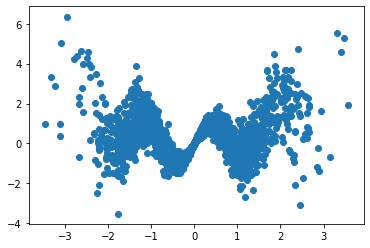

In [323]:
# Simulate data
num_obs = 3000
x, y = simulate_data(shape=(num_obs, 1), sd=.3)

# Plot data
plt.scatter(x, y)
plt.show()

In [284]:
tf.random.set_seed(0)

go_bayesian = True

if go_bayesian:
    # Bayesian model
    model = tf.keras.Sequential([
        tfp.layers.DenseVariational(8,
                                    make_default_dense_guide,
                                    make_default_dense_prior,
                                    activation='sigmoid',
                                    kl_weight=1/num_obs),
        tfp.layers.DenseVariational(2,
                                    make_default_dense_guide,
                                    make_default_dense_prior,
                                    kl_weight=1/num_obs),
        tfp.layers.DistributionLambda(lambda t:
            # NOTE: `t[:, :1] != t[:, 0]` and `t[:, 1:] != t[:, 1]`.
            # This will be clear by inspecting the shapes.
            tfd.Normal(t[..., :1], centered_softplus(t[..., 1:]))
        )
    ])
else:
    # Model
    reg = tf.keras.regularizers.l2(0)
    act = 'sigmoid'
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(8, kernel_regularizer=reg, activation=act),
        tf.keras.layers.Dense(2, kernel_regularizer=reg),
        tfp.layers.DistributionLambda(lambda t:
            tfd.Normal(t[:, :1], centered_softplus(t[:, 1:]))
        )
    ])
    
model(x);

In [337]:
if go_bayesian:
    opt = tf.keras.optimizers.Adam(.1)
    model.compile(optimizer=opt, loss=util.neg_loglike)
else:
    opt = tf.keras.optimizers.Adam(.1)
    # model.compile(optimizer=opt, loss='mse')
    model.compile(optimizer=opt, loss=util.neg_loglike)

In [338]:
model.summary()

Model: "sequential_133"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational_61 (DenseV multiple                  32        
_________________________________________________________________
dense_variational_62 (DenseV multiple                  36        
_________________________________________________________________
distribution_lambda_147 (Dis multiple                  0         
Total params: 68
Trainable params: 68
Non-trainable params: 0
_________________________________________________________________


In [353]:
if go_bayesian:
    history = model.fit(x, y, epochs=500, batch_size=512)
else: 
    history = model.fit(x, y, epochs=100, batch_size=512)

Train on 3000 samples
Epoch 1/500
3000/3000 [==============================] - 0s 12us/sample - loss: 3.6642
Epoch 2/500
3000/3000 [==============================] - 0s 8us/sample - loss: 3.6492
Epoch 3/500
3000/3000 [==============================] - 0s 7us/sample - loss: 3.6897
Epoch 4/500
3000/3000 [==============================] - 0s 7us/sample - loss: 3.6754
Epoch 5/500
3000/3000 [==============================] - 0s 7us/sample - loss: 3.6373
Epoch 6/500
3000/3000 [==============================] - 0s 7us/sample - loss: 3.6689
Epoch 7/500
3000/3000 [==============================] - 0s 6us/sample - loss: 3.6408
Epoch 8/500
3000/3000 [==============================] - 0s 8us/sample - loss: 3.6459
Epoch 9/500
3000/3000 [==============================] - 0s 8us/sample - loss: 3.6856
Epoch 10/500
3000/3000 [==============================] - 0s 8us/sample - loss: 3.6402
Epoch 11/500
3000/3000 [==============================] - 0s 8us/sample - loss: 3.6760
Epoch 12/500
3000/3000 [=====

3000/3000 [==============================] - 0s 8us/sample - loss: 3.6472
Epoch 95/500
3000/3000 [==============================] - 0s 7us/sample - loss: 3.6589
Epoch 96/500
3000/3000 [==============================] - 0s 8us/sample - loss: 3.6629
Epoch 97/500
3000/3000 [==============================] - 0s 7us/sample - loss: 3.6564
Epoch 98/500
3000/3000 [==============================] - 0s 6us/sample - loss: 3.6373
Epoch 99/500
3000/3000 [==============================] - 0s 8us/sample - loss: 3.6841
Epoch 100/500
3000/3000 [==============================] - 0s 15us/sample - loss: 3.6568
Epoch 101/500
3000/3000 [==============================] - 0s 13us/sample - loss: 3.6672
Epoch 102/500
3000/3000 [==============================] - 0s 14us/sample - loss: 3.6381
Epoch 103/500
3000/3000 [==============================] - 0s 13us/sample - loss: 3.6774
Epoch 104/500
3000/3000 [==============================] - 0s 14us/sample - loss: 3.6397
Epoch 105/500
3000/3000 [=====================

3000/3000 [==============================] - 0s 7us/sample - loss: 4.2759
Epoch 187/500
3000/3000 [==============================] - 0s 9us/sample - loss: 4.2372
Epoch 188/500
3000/3000 [==============================] - 0s 7us/sample - loss: 4.1968
Epoch 189/500
3000/3000 [==============================] - 0s 9us/sample - loss: 4.1606
Epoch 190/500
3000/3000 [==============================] - 0s 10us/sample - loss: 4.2405
Epoch 191/500
3000/3000 [==============================] - 0s 9us/sample - loss: 4.2562
Epoch 192/500
3000/3000 [==============================] - 0s 8us/sample - loss: 4.2384
Epoch 193/500
3000/3000 [==============================] - 0s 6us/sample - loss: 4.2588
Epoch 194/500
3000/3000 [==============================] - 0s 6us/sample - loss: 4.3139
Epoch 195/500
3000/3000 [==============================] - 0s 6us/sample - loss: 4.2212
Epoch 196/500
3000/3000 [==============================] - 0s 9us/sample - loss: 4.3481
Epoch 197/500
3000/3000 [====================

3000/3000 [==============================] - 0s 6us/sample - loss: 4.1936
Epoch 279/500
3000/3000 [==============================] - 0s 8us/sample - loss: 4.2446
Epoch 280/500
3000/3000 [==============================] - 0s 6us/sample - loss: 4.2041
Epoch 281/500
3000/3000 [==============================] - 0s 8us/sample - loss: 4.3090
Epoch 282/500
3000/3000 [==============================] - 0s 6us/sample - loss: 4.1629
Epoch 283/500
3000/3000 [==============================] - 0s 6us/sample - loss: 4.2625
Epoch 284/500
3000/3000 [==============================] - 0s 7us/sample - loss: 4.2503
Epoch 285/500
3000/3000 [==============================] - 0s 12us/sample - loss: 4.2181
Epoch 286/500
3000/3000 [==============================] - 0s 13us/sample - loss: 4.2318
Epoch 287/500
3000/3000 [==============================] - 0s 11us/sample - loss: 4.1631
Epoch 288/500
3000/3000 [==============================] - 0s 13us/sample - loss: 4.2195
Epoch 289/500
3000/3000 [=================

3000/3000 [==============================] - 0s 7us/sample - loss: 4.2535
Epoch 371/500
3000/3000 [==============================] - 0s 6us/sample - loss: 4.2807
Epoch 372/500
3000/3000 [==============================] - 0s 6us/sample - loss: 4.2264
Epoch 373/500
3000/3000 [==============================] - 0s 10us/sample - loss: 4.1966
Epoch 374/500
3000/3000 [==============================] - 0s 7us/sample - loss: 4.1993
Epoch 375/500
3000/3000 [==============================] - 0s 8us/sample - loss: 4.1242
Epoch 376/500
3000/3000 [==============================] - 0s 7us/sample - loss: 4.2208
Epoch 377/500
3000/3000 [==============================] - 0s 7us/sample - loss: 4.1573
Epoch 378/500
3000/3000 [==============================] - 0s 8us/sample - loss: 4.2129
Epoch 379/500
3000/3000 [==============================] - 0s 7us/sample - loss: 4.2387
Epoch 380/500
3000/3000 [==============================] - 0s 8us/sample - loss: 4.1970
Epoch 381/500
3000/3000 [====================

3000/3000 [==============================] - 0s 9us/sample - loss: 4.2239
Epoch 463/500
3000/3000 [==============================] - 0s 9us/sample - loss: 4.2282
Epoch 464/500
3000/3000 [==============================] - 0s 10us/sample - loss: 4.2056
Epoch 465/500
3000/3000 [==============================] - 0s 11us/sample - loss: 4.2136
Epoch 466/500
3000/3000 [==============================] - 0s 11us/sample - loss: 4.2110
Epoch 467/500
3000/3000 [==============================] - 0s 10us/sample - loss: 4.1000
Epoch 468/500
3000/3000 [==============================] - 0s 11us/sample - loss: 4.1351
Epoch 469/500
3000/3000 [==============================] - 0s 10us/sample - loss: 4.1678
Epoch 470/500
3000/3000 [==============================] - 0s 9us/sample - loss: 4.2434
Epoch 471/500
3000/3000 [==============================] - 0s 9us/sample - loss: 4.1002
Epoch 472/500
3000/3000 [==============================] - 0s 11us/sample - loss: 4.2049
Epoch 473/500
3000/3000 [==============

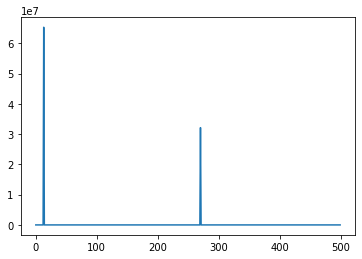

In [336]:
plt.plot(history.history['loss'])
plt.show()

In [289]:
# Make predictions at new locations
x_new = np.linspace(-4, 4, 100).reshape(-1, 1)

if go_bayesian:
    preds = np.stack([model.predict(x_new).squeeze() for _ in trange(32)], axis=1)
    preds_mean = preds.mean(1)
    preds_lower = np.quantile(preds, .025, 1)
    preds_upper = np.quantile(preds, .975, 1)
else:
    # preds_mean = model.predict(x_new)
    preds = np.stack([model.predict(x_new).squeeze() for _ in trange(32)], axis=1)
    preds_mean = preds.mean(1)
    preds_lower = np.quantile(preds, .025, 1)
    preds_upper = np.quantile(preds, .975, 1)

100%|██████████| 32/32 [00:02<00:00, 10.56it/s]


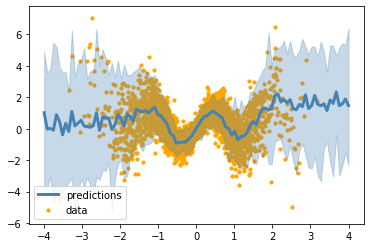

In [290]:
plt.plot(x_new.squeeze(), preds_mean, label='predictions', zorder=2, lw=3, c='steelblue')
plt.fill_between(x_new.squeeze(), preds_lower, preds_upper, color='steelblue', alpha=.3, zorder=2)
plt.scatter(x.squeeze(), y.squeeze(), label='data', zorder=1, c='orange', s=10)
plt.legend()
plt.show()

In [319]:
y_new = simulate_data(x_new, sd=.3)[1].squeeze()
np.mean((preds_lower < y_new) & (y_new < preds_upper))


0.87